<a href="https://colab.research.google.com/github/pedrohortencio/covid-brasil/blob/main/tratamento_dados_sus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import urllib.request
import os
from collections import Counter

# Opção para que o Pandas não formate os números para notação científica
pd.set_option('display.float_format', str)
#pd.set_option('display.max_rows', 100)
#pd.reset_option("all")

URL_2019 = 'https://raw.githubusercontent.com/pedrohortencio/covid-brasil/main/Dados/SUS/2019-total.csv'
URL_2020 = 'https://raw.githubusercontent.com/pedrohortencio/covid-brasil/main/Dados/SUS/2020-total.csv'
CAMINHO_2019 = '/content/dados-2019-tot.csv'
CAMINHO_2020 = '/content/dados-2020-tot.csv'

MESES = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", 
         "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]

# Download dos Dados

In [37]:
def baixar_dados():
    # Baixa um .txt que contém a URL dos 24 .csv que compõe os dados mensais do SUS entre 2019 e 2020
    urls_dados_sus = 'https://raw.githubusercontent.com/pedrohortencio/covid-brasil/main/Dados/url-dados-sus.txt'
    _, _ = urllib.request.urlretrieve(urls_dados_sus, filename="/content/url-dados-sus.txt")
    # Abre o arquivo
    with open('/content/url-dados-sus.txt') as f:
        urls_csvs_sus = [line.rstrip() for line in f]   # cria uma lista com as URL

    # Cria os diretórios para os dados
    try:
        os.mkdir('/content/2019')
        os.mkdir('/content/2020')
    except:
        pass
    lista_caminhos = []
    # Percorre a lista baixando os arquivos
    for url in urls_csvs_sus:
        # Há duas linhas com valores '2019' e '2020'
        if url == '2019':
            pasta = '2019'  # altera o valor da variável pasta quando a linha for '2019'
            continue    # próxima iteração do loop
        elif url == '2020': 
            pasta = '2020'  # altera o valor para 2020
            continue    # próxima iteração do loop
        
        
        nome_arquivo = re.search('[0-9\-a-zA-Z]*[0-9]+.[a-z]+', url).group(0)   # Filtra o nome do arquivo da URL
        caminho = f"/content/{pasta}/{nome_arquivo}"    # Cria uma String com o caminho do arquivo
        lista_caminhos.append(caminho)
        _, _ = urllib.request.urlretrieve(url, filename=caminho) # Requisição do arquivo, salvando na pasta criada anteriormente
    return lista_caminhos

# Limpeza dos Dados

In [33]:
def ler_df_anual(caminho):
    df = pd.read_csv(caminho, sep=';', encoding='latin-1', header=4, decimal=',')   # lê o arquivo e cria um DataFrame
    df.dropna(axis = 0, thresh=9, inplace = True)

    df.replace({'-':0}, inplace=True)

    df['Óbitos'] = pd.to_numeric(df['Óbitos'], errors='coerce')
    df['Taxa_mortalidade'] = df['Taxa_mortalidade'].apply(lambda x: float(str(x).replace(',', '.')))

    ######################
    # Sanity check 1
        ### Verifica se há algum valor nulo em alguma coluna do DataFrame
    lista_valores_nulos = df.isnull().sum().sort_values(ascending=False).values
    for valor in lista_valores_nulos:
        if valor != 0:
            # Se sim, levanta uma exceção
            raise Exception("Há valores nulos no dataframe")

    # Sanity check 2
        ### Verifica se os dtypes do dataframe são os dtypes corretos, estabelecidos durante os testes
    lista_dtypes_corretos = [np.dtype('O'), np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('int64'), np.dtype('float64')]

    lista_dtypes = df.dtypes.values
    comparacao = lista_dtypes_corretos == lista_dtypes

    for i in comparacao:
        if np.logical_not(i):   # Se o valor i da lista é Falso
            raise Exception("Há dtypes incorretos no dataframe")
    #######################

    # Filtra as linhas onde a coluna "Lista Morb CID-10" exibe um dos capítulos do CID (1-21)
    df_grupo_cid = df[df['Lista Morb  CID-10'].str.match(r'[0-9]+')]

    lista_caps_cid = list(df_grupo_cid['Lista Morb  CID-10'].values)

    range_index = list(df_grupo_cid['Lista Morb  CID-10'].index)

    lista_qtd_repeticoes = []
    for indice, valor in enumerate(range_index):
        if indice == 19:
            diferenca = df.index[-1] - valor + 1
            lista_qtd_repeticoes.append(diferenca)
            continue
        
        diferenca = range_index[indice+1] - valor
        lista_qtd_repeticoes.append(diferenca)

    index_grupos_cid = []
    for grupo_cid, qtd_repeticoes in zip(lista_caps_cid, lista_qtd_repeticoes):
        for i in range(qtd_repeticoes):
            index_grupos_cid.append(grupo_cid.title())

    index_grupos_cid[-1] = 'Total'  # O último item do índice hierárquico será o valor total das colunas

    #########
    # Sanity Check 3
        ### Verifica se o tamanho da lista de grupos CID, para indexar hierarquicamente o dataframe, está correta
    if len(index_grupos_cid) != 348:
        raise Exception("Tamanho da lista de grupos CID, para indexação do DataFrame, não corresponde a 348 entradas")
    #########

    # Cria um índice hierárquico
    df.set_index([index_grupos_cid, [i for i in range(348)]], inplace=True)

    # Troca o valor da linha, na coluna 'Lista Morb  CID-10', para refletir o total do grupo
    df.loc[df.loc[:]['Lista Morb  CID-10'].str.match(r'[0-9]+'), 'Lista Morb  CID-10'] = 'Total do Grupo'

    # Retira os pontos no início das strings dos valores da coluna 'Lista Morb  CID-10'
    df.loc[:]['Lista Morb  CID-10'] = df.loc[:]['Lista Morb  CID-10'].apply(lambda x: x.strip('.'))

    return df

In [83]:
def ler_df(caminho):
    df = pd.read_csv(caminho, sep=';', encoding='latin-1', header=4, decimal=',')   # lê o arquivo e cria um DataFrame
    df.dropna(axis = 0, thresh=9, inplace = True)   # Dropa linhas que contenham mais de 9 valores NaN.

    ### O Ministério da Saúde convencionou que "Dados numéricos iguais a 0, não resultantes de arredondamento" são
    #representados por "-" (informação disponível no TabNet). Assim, esse valor será substituído por 0:
    df.replace({'-':0}, inplace=True)

    # Transforma a coluna "Óbitos" em valores numéricos (int64)
    df['Óbitos'] = pd.to_numeric(df['Óbitos'], errors='coerce')     # erros='coerce' faz com que valores problemáticos sejam inseridos como NaN
    # Converte a coluna "Taxa_mortalidade" para float64
    df['Taxa_mortalidade'] = df['Taxa_mortalidade'].apply(lambda x: float(str(x).replace(',', '.')))    #substitui a vírgula do decimal por ponto, converte para float64
    df['Média_permanência'] = df['Média_permanência'].apply(lambda x: float(str(x).replace(',', '.')))
    df['Dias_permanência'] = df['Dias_permanência'].apply(lambda x: float(str(x))) 

    ##################
    # Sanity check 1
        ### Verifica se há algum valor nulo em alguma coluna do DataFrame
    lista_valores_nulos = df.isnull().sum().sort_values(ascending=False).values
    for valor in lista_valores_nulos:
        if valor != 0:
            # Se sim, levanta uma exceção
            raise Exception("Há valores nulos no dataframe")

    # Sanity check 2
        ### Verifica se os dtypes do dataframe são os dtypes corretos, estabelecidos durante os testes
    lista_dtypes_corretos = [np.dtype('O'), np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('float64'), np.dtype('float64'), np.dtype('float64'),
        np.dtype('int64'), np.dtype('float64')]

    lista_dtypes = df.dtypes.values
    comparacao = lista_dtypes_corretos == lista_dtypes

    for i in comparacao:
        if np.logical_not(i):   # Se o valor i da lista é Falso
            raise Exception("Há dtypes incorretos no dataframe")
    #######################

    ### Criando um Índice Hierárquivo

    # Filtra as linhas onde a coluna "Lista Morb CID-10" exibe um dos capítulos do CID (1-21)
    df_grupo_cid = df[df['Lista Morb  CID-10'].str.match(r'[0-9]+')]

    lista_caps_cid = list(df_grupo_cid['Lista Morb  CID-10'].values)

    range_index = list(df_grupo_cid['Lista Morb  CID-10'].index)

    lista_qtd_repeticoes = []
    for indice, valor in enumerate(range_index):
        if indice == 19:
            diferenca = df.index[-1] - valor + 1
            lista_qtd_repeticoes.append(diferenca)
            continue
        
        diferenca = range_index[indice+1] - valor
        lista_qtd_repeticoes.append(diferenca)

    index_grupos_cid = []
    for grupo_cid, qtd_repeticoes in zip(lista_caps_cid, lista_qtd_repeticoes):
        for i in range(qtd_repeticoes):
            index_grupos_cid.append(grupo_cid.title())

    index_grupos_cid[-1] = 'Total'  # O último item do índice hierárquico será o valor total das colunas

    #########
    # Sanity Check 3
        ### Verifica se o tamanho da lista de grupos CID, para indexar hierarquicamente o dataframe, está correta
    #if len(index_grupos_cid) != 341:
    #    raise Exception("Tamanho da lista de grupos CID, para indexação do DataFrame, não corresponde a 341 entradas")
    #########

    # Cria um índice hierárquico
    df.set_index([index_grupos_cid, [i for i in range(len(index_grupos_cid))]], inplace=True)

    # Troca o valor da linha, na coluna 'Lista Morb  CID-10', para refletir o total do grupo
    df.loc[df.loc[:]['Lista Morb  CID-10'].str.match(r'[0-9]+'), 'Lista Morb  CID-10'] = 'Total do Grupo'

    # Retira os pontos no início das strings dos valores da coluna 'Lista Morb  CID-10'
    df.loc[:]['Lista Morb  CID-10'] = df.loc[:]['Lista Morb  CID-10'].apply(lambda x: x.strip('.'))

    return df

# Criação dos DataFrames

In [ ]:
def criar_df_mensal():
    lista_caminhos = baixar_dados()
    dict_df_2019 = {}
    dict_df_2020 = {}
    for indice, caminho in enumerate(lista_caminhos):
        if '2019' in caminho:
            mes = MESES[indice]
            print(mes)
            df = ler_df(caminho)
            dict_df_2019[mes] = df
        elif '2020' in caminho:
            mes = MESES[indice-12]
            print(mes)
            df = ler_df(caminho)
            dict_df_2020[mes] = df
        else:
            raise ("Erro no caminho. Finalizado em ", caminho, indice)
    return dict_df_2019, dict_df_2020

In [ ]:
def criar_df_anual(ano):
    if ano == 2019:
        _, _ = urllib.request.urlretrieve(URL_2019, filename=CAMINHO_2019)
        df = ler_df_anual(CAMINHO_2019)
        return df
    elif ano == 2020:
        _, _ = urllib.request.urlretrieve(URL_2020, filename=CAMINHO_2020)
        df = ler_df_anual(CAMINHO_2020)
        return df
    else:
        print("Ano inválido")

# Testes de Importação e Plot

In [13]:
#pd.reset_option("all")
pd.set_option('display.max_rows', 500)

In [123]:
df1 = ler_df('/content/2019/01-2019.csv')
df2 = ler_df('/content/2019/02-2019.csv')

In [124]:
df_teste = dict_df_2019['Fevereiro']

In [125]:
# Sanity Check
df_teste.equals(df2)

True

In [126]:
df2.head(2)

Lista Morb  CID-10  ...  Taxa_mortalidade
01 Algumas Doenças Infecciosas E Parasitárias 0     Total do Grupo  ...             11.29
                                              1             Cólera  ...             10.81

[2 rows x 12 columns]

In [128]:
df_teste.head(2)

Lista Morb  CID-10  ...  Taxa_mortalidade
01 Algumas Doenças Infecciosas E Parasitárias 0     Total do Grupo  ...             11.29
                                              1             Cólera  ...             10.81

[2 rows x 12 columns]

In [ ]:
df2.loc["Total"][["Internações", "Óbitos"]]

,Internações,Óbitos
340,744107.0,36727


In [ ]:
df2.loc["Total"][["Internações", "Óbitos"]].values[0]

array([744107.,  36727.])

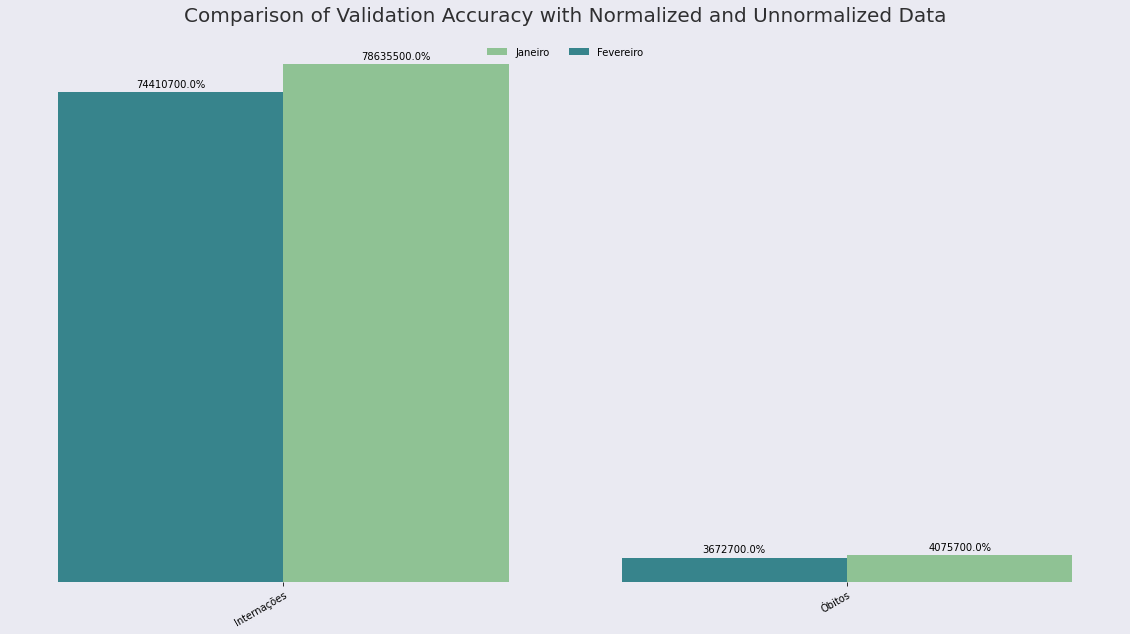

In [ ]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

lista_ticks =["Internações", "Óbitos"]

ax = plt.gca()
width = 0.40

rects1 = ax.bar(lista_ticks, df1.loc["Total"][["Internações", "Óbitos"]].values[0], width,align='edge', color = '#8FC294', label='Janeiro')
rects2 = ax.bar(lista_ticks, df2.loc["Total"][["Internações", "Óbitos"]].values[0], -width, align='edge', color = '#37848C', label='Fevereiro')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Validation Accuracy with Normalized and Unnormalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# displays the plot
plt.show();

In [ ]:
df2

Lista Morb  CID-10  ...  Taxa_mortalidade
01 Algumas Doenças Infecciosas E Parasitárias    0                                      Total do Grupo  ...             11.29
                                                 1                                              Cólera  ...             10.81
                                                 2                        Febres tifóide e paratifóide  ...               0.0
                                                 3                                          Shiguelose  ...               0.0
                                                 4                                            Amebíase  ...              1.54
                                                 5      Diarréia e gastroenterite origem infecc presum  ...              0.73
                                                 6              Outras doenças infecciosas intestinais  ...              0.69
                                                 7                            Tuberculose respiratória  ...              8.13
                                                 8                                Tuberculose pulmonar  ...              7.67
                                                 9                   Outras tuberculoses respiratórias  ...              9.35
                                                 10                                Outras tuberculoses  ...              8.33
                                                 11                     Tuberculose do sistema nervoso  ...             14.29
                                                 12        Tuberc intest peritônio glângl mesentéricos  ...              10.0
                                                 13               Tuberculose óssea e das articulações  ...               0.0
                                                 14                                 Tuberculose miliar  ...               9.3
                                                 15                    Restante de outras tuberculoses  ...              3.45
                                                 16                                              Peste  ...             66.67
                                                 17                                          Brucelose  ...               0.0
                                                 18                                 Hanseníase [lepra]  ...              2.63
                                                 19                                     Outros tétanos  ...               0.0
                                                 20                                           Difteria  ...               0.0
                                                 21                                         Coqueluche  ...               0.0
                                                 22                             Infecção meningocócica  ...             10.14
                                                 23                                         Septicemia  ...             44.68
                                                 24                         Outras doenças bacterianas  ...              9.17
                                                 25                     Leptospirose icterohemorrágica  ...             17.65
                                                 26                      Outras formas de leptospirose  ...              5.56
                                                 27                      Leptospirose não especificada  ...              0.43
                                                 28             Restante de outras doenças bacterianas  ...              9.27
                                                 29                                  Sífilis congênita  ...              0.14
                                                 30                                    Sífilis precoce  ...               2.5
                                                 31 

In [ ]:
df1

Lista Morb  CID-10  ...  Taxa_mortalidade
01 Algumas Doenças Infecciosas E Parasitárias    0                                      Total do Grupo  ...             12.27
                                                 1                                              Cólera  ...              4.44
                                                 2                        Febres tifóide e paratifóide  ...               0.0
                                                 3                                          Shiguelose  ...               0.0
                                                 4                                            Amebíase  ...               0.0
                                                 5      Diarréia e gastroenterite origem infecc presum  ...              0.97
                                                 6              Outras doenças infecciosas intestinais  ...              0.73
                                                 7                            Tuberculose respiratória  ...              7.87
                                                 8                                Tuberculose pulmonar  ...              7.31
                                                 9                   Outras tuberculoses respiratórias  ...              9.33
                                                 10                                Outras tuberculoses  ...               9.8
                                                 11                     Tuberculose do sistema nervoso  ...             12.12
                                                 12        Tuberc intest peritônio glângl mesentéricos  ...               0.0
                                                 13               Tuberculose óssea e das articulações  ...               0.0
                                                 14              Tuberculose do aparelho geniturinário  ...               0.0
                                                 15                                 Tuberculose miliar  ...             15.71
                                                 16                    Restante de outras tuberculoses  ...               0.0
                                                 17                                              Peste  ...               0.0
                                                 18                                          Brucelose  ...               0.0
                                                 19                                 Hanseníase [lepra]  ...               1.7
                                                 20                                     Outros tétanos  ...             23.53
                                                 21                                           Difteria  ...               0.0
                                                 22                                         Coqueluche  ...              0.71
                                                 23                             Infecção meningocócica  ...              16.3
                                                 24                                         Septicemia  ...             45.38
                                                 25                         Outras doenças bacterianas  ...             10.19
                                                 26                     Leptospirose icterohemorrágica  ...              6.25
                                                 27                      Outras formas de leptospirose  ...               0.0
                                                 28                      Leptospirose não especificada  ...              2.08
                                                 29             Restante de outras doenças bacterianas  ...             10.28
                                                 30                                  Sífilis congênita  ...              0.28
                                                 31 

In [ ]:
df.head(5)

Lista Morb  CID-10  ...  Taxa_mortalidade
01 Algumas doenças infecciosas e parasitárias 0  01 Algumas doenças infecciosas e parasitárias  ...             11.29
                                              1                                      .. Cólera  ...             10.81
                                              2                .. Febres tifóide e paratifóide  ...               0.0
                                              3                                  .. Shiguelose  ...               0.0
                                              4                                    .. Amebíase  ...              1.54

[5 rows x 12 columns]

In [ ]:
df.head(10)

In [ ]:
df.tail()